# TabPFN精简版：性早熟预测模型

**使用精简特征集（9个特征）进行模型训练**

精简特征基于医生临床经验筛选：
- LH/FSH 相关：基础LH、基础FSH、LH/FSH比值
- 骨龄相关：骨龄、骨龄与实际年龄比值
- 子宫卵巢径线/体积：子宫长宽厚体积、左右卵巢长宽厚体积、卵巢平均值

本笔记本流程与 TabPFN_Enhanced.ipynb 一致：
- 基础TabPFN模型
- 超参数优化（HPO）
- Post-hoc集成（AutoTabPFN）
- SHAP可解释性分析

## 1. 导入必要的库

In [1]:
import os

os.environ["SCIPY_ARRAY_API"] = "1"

import pandas as pd
import numpy as np
import warnings
import joblib

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# TabPFN相关库
from tabpfn import TabPFNClassifier
from tabpfn_extensions.hpo import TunedTabPFNClassifier
from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier
from tabpfn_extensions import interpretability

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

print("所有库导入完成")

所有库导入完成


## 2. 设置路径和参数

In [2]:
os.makedirs("./output", exist_ok=True)
os.makedirs("./output/models", exist_ok=True)
os.makedirs("./output/tabpfn_simplified", exist_ok=True)
os.makedirs("./output/tabpfn_simplified/models", exist_ok=True)

RANDOM_SEED = 825
np.random.seed(RANDOM_SEED)
N_JOBS = -1

print(f"随机种子设置: {RANDOM_SEED}")
print(f"输出目录: ./output/tabpfn_simplified/")

随机种子设置: 825
输出目录: ./output/tabpfn_simplified/


## 3. 读取精简特征数据

In [3]:
normal_data = pd.read_csv("./input/性早熟数据激发试验正常组_simplified.csv")
disease_data = pd.read_csv("./input/激发试验确诊性早熟组数据_simplified.csv")

normal_data["group"] = "N"
disease_data["group"] = "Y"

print(f"正常组: {normal_data.shape[0]} 行, {normal_data.shape[1]} 列")
print(f"早熟组: {disease_data.shape[0]} 行, {disease_data.shape[1]} 列")
print(f"\n精简特征列表:")
for col in normal_data.columns:
    if col not in ["group", "患者编号"]:
        print(f"  - {col}")

正常组: 4009 行, 11 列
早熟组: 5877 行, 11 列

精简特征列表:
  - 基础血清促黄体生成激素（LH）
  - 基础血清卵泡刺激素（FSH）
  - 骨龄(岁)
  - 骨龄与实际年龄比值
  - 子宫长（cm）
  - 子宫厚（cm）
  - 左卵巢体积（长X宽X厚X0.5233）
  - 右卵巢体积（长X宽X厚X0.5233）
  - LH/FSH比值


## 4. 数据类型处理和合并

In [ ]:
# 分组填补：先对每组分别填补，再合并
exclude_cols = ["group", "患者编号", "Unnamed: 0"]
feature_cols = [col for col in normal_data.columns if col not in exclude_cols]

print(f"使用 {len(feature_cols)} 个精简特征")
print("使用MissForest方法进行分组填补...")

# 分别对正常组和性早熟组进行填补
imputer_normal = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=10, max_depth=10, n_jobs=-1, random_state=RANDOM_SEED
    ),
    max_iter=10,
    random_state=RANDOM_SEED,
    verbose=0,
)
imputer_disease = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=10, max_depth=10, n_jobs=-1, random_state=RANDOM_SEED
    ),
    max_iter=10,
    random_state=RANDOM_SEED,
    verbose=0,
)

normal_features = normal_data[feature_cols].copy()
disease_features = disease_data[feature_cols].copy()

normal_imputed = pd.DataFrame(
    imputer_normal.fit_transform(normal_features), columns=feature_cols
)
disease_imputed = pd.DataFrame(
    imputer_disease.fit_transform(disease_features), columns=feature_cols
)

print(f"正常组填补完成: {normal_imputed.shape}")
print(f"性早熟组填补完成: {disease_imputed.shape}")

# 添加标签列
normal_imputed["group"] = "N"
disease_imputed["group"] = "Y"

# 合并数据
data = pd.concat([normal_imputed, disease_imputed], axis=0, ignore_index=True)
data["group"] = data["group"].astype("category")
print(f"\n合并后数据: {data.shape[0]} 行 x {data.shape[1]} 列")
print(f"分组统计:\n{data['group'].value_counts()}")

合并后数据: 9886 行 x 11 列
分组统计:
group
Y    5877
N    4009
Name: count, dtype: int64


## 5. 划分训练集和验证集

In [5]:
train_data, validation_data = train_test_split(
    data, test_size=0.3, stratify=data["group"], random_state=RANDOM_SEED
)

print(f"训练集: {train_data.shape[0]} 行, 验证集: {validation_data.shape[0]} 行")

训练集: 6920 行, 验证集: 2966 行


## 6. 特征工程

In [6]:
exclude_cols = ["group", "患者编号", "Unnamed: 0"]
feature_cols = [col for col in train_data.columns if col not in exclude_cols]

X_train = train_data[feature_cols].copy()
y_train = train_data["group"].copy()
X_validation = validation_data[feature_cols].copy()
y_validation = validation_data["group"].copy()

y_train_binary = (y_train == "Y").astype(int)
y_validation_binary = (y_validation == "Y").astype(int)

print(f"使用 {len(feature_cols)} 个精简特征")
print(f"训练集正负样本: {y_train_binary.value_counts().to_dict()}")
print(f"验证集正负样本: {y_validation_binary.value_counts().to_dict()}")

使用 9 个精简特征
训练集正负样本: {1: 4114, 0: 2806}
验证集正负样本: {1: 1763, 0: 1203}


## 7. 数据预处理（缺失值填充）

In [ ]:
# 数据已在分组填补阶段完成，直接使用
X_train_processed = X_train.values
X_validation_processed = X_validation.values

feature_cols_processed = feature_cols
print(f"预处理完成！特征数: {X_train_processed.shape[1]}")

使用MissForest方法填补缺失值...
预处理完成！特征数: 9


---
# 模型训练与优化

## 8. 准备训练数据

In [8]:
max_samples = 50000

if len(X_train_processed) > max_samples:
    print(f"训练集样本数({len(X_train_processed)})超过{max_samples}，进行分层采样")

    sss = StratifiedShuffleSplit(
        n_splits=1, train_size=max_samples, random_state=RANDOM_SEED
    )
    for sample_idx, _ in sss.split(X_train_processed, y_train_binary):
        X_train_sampled = X_train_processed[sample_idx]
        y_train_sampled = y_train_binary.iloc[sample_idx].values

    print(f"采样后类别分布: {np.bincount(y_train_sampled)}")
else:
    X_train_sampled = X_train_processed
    y_train_sampled = y_train_binary.values
    print(f"使用{len(X_train_sampled)}个训练样本")

print(f"训练样本: {len(X_train_sampled)}, 特征数: {X_train_sampled.shape[1]}")

使用6920个训练样本
训练样本: 6920, 特征数: 9


## 9. 模型1：基础TabPFN

In [ ]:
print("=" * 70)
print("训练基础TabPFN模型（精简特征）")
print("=" * 70)
from tabpfn.inference_tuning import ClassifierTuningConfig

tabpfn_basic = TabPFNClassifier(
    n_estimators=32,
    device="cuda",
    random_state=RANDOM_SEED,
    eval_metric="f1",
    tuning_config=ClassifierTuningConfig(
        calibrate_temperature=True,
        tune_decision_thresholds=True,
    ),
)

print(f"  - 训练样本数: {len(X_train_sampled)}")
print(f"  - 特征数: {X_train_sampled.shape[1]}")
print("\n开始训练...")

tabpfn_basic.fit(X_train_sampled, y_train_sampled)

y_pred_basic = tabpfn_basic.predict(X_validation_processed)
y_pred_proba_basic = tabpfn_basic.predict_proba(X_validation_processed)[:, 1]

auc_basic = roc_auc_score(y_validation_binary, y_pred_proba_basic)
f1_basic = f1_score(y_validation_binary, y_pred_basic)
acc_basic = accuracy_score(y_validation_binary, y_pred_basic)

print(f"\n基础TabPFN性能 (精简特征):")
print(f"  AUC: {auc_basic:.4f}")
print(f"  F1:  {f1_basic:.4f}")
print(f"  ACC: {acc_basic:.4f}")

# 保存模型
joblib.dump(
    {
        "model": tabpfn_basic,
        "imputer_normal": imputer_normal,
        "imputer_disease": imputer_disease,
    },
    "./output/tabpfn_simplified/models/tabpfn_basic.pkl",
)
print(f"\n模型已保存: ./output/tabpfn_simplified/models/tabpfn_basic.pkl")

训练基础TabPFN模型（精简特征）
  - 训练样本数: 6920
  - 特征数: 9

开始训练...

基础TabPFN性能 (精简特征):
  AUC: 0.8232
  F1:  0.8181
  ACC: 0.7613

模型已保存: ./output/tabpfn_simplified/models/tabpfn_basic.pkl


## 10. 模型2：超参数优化（HPO）

In [ ]:
print("=" * 70)
print("训练HPO优化TabPFN模型（精简特征）")
print("=" * 70)

tabpfn_hpo = TunedTabPFNClassifier(
    n_trials=2000,
    metric="f1",
    device="cuda",
    random_state=RANDOM_SEED,
    verbose=True,
)

print("开始超参数搜索...")
tabpfn_hpo.fit(X_train_sampled, y_train_sampled)

y_pred_hpo = tabpfn_hpo.predict(X_validation_processed)
y_pred_proba_hpo = tabpfn_hpo.predict_proba(X_validation_processed)[:, 1]

auc_hpo = roc_auc_score(y_validation_binary, y_pred_proba_hpo)
f1_hpo = f1_score(y_validation_binary, y_pred_hpo)
acc_hpo = accuracy_score(y_validation_binary, y_pred_hpo)

print(f"\nHPO优化TabPFN性能 (精简特征):")
print(f"  AUC: {auc_hpo:.4f}")
print(f"  F1:  {f1_hpo:.4f}")
print(f"  ACC: {acc_hpo:.4f}")

# 保存模型
joblib.dump(
    {
        "model": tabpfn_hpo,
        "imputer_normal": imputer_normal,
        "imputer_disease": imputer_disease,
    },
    "./output/tabpfn_simplified/models/tabpfn_hpo.pkl",
)
print(f"\n模型已保存: ./output/tabpfn_simplified/models/tabpfn_hpo.pkl")

## 11. 模型3：Post-hoc集成（AutoTabPFN）

In [ ]:
print("=" * 70)
print("训练Post-hoc集成TabPFN模型（精简特征）")
print("=" * 70)

import torch
import ray

print(f"PyTorch CUDA 可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU 设备: {torch.cuda.get_device_name(0)}")

tabpfn_auto = AutoTabPFNClassifier(
    max_time=12600,  # 3.5h
    presets="best_quality",
    device="cuda:0",
    ignore_pretraining_limits=True,
)

print("模型初始化成功")
print(f"训练样本数: {len(X_train_sampled)}")
print("开始自动集成训练...")

tabpfn_auto.fit(X_train_sampled, y_train_sampled)

y_pred_auto = tabpfn_auto.predict(X_validation_processed)
y_pred_proba_auto = tabpfn_auto.predict_proba(X_validation_processed)[:, 1]

auc_auto = roc_auc_score(y_validation_binary, y_pred_proba_auto)
f1_auto = f1_score(y_validation_binary, y_pred_auto)
acc_auto = accuracy_score(y_validation_binary, y_pred_auto)

print(f"\nPost-hoc集成TabPFN性能 (精简特征):")
print(f"  AUC: {auc_auto:.4f}")
print(f"  F1:  {f1_auto:.4f}")
print(f"  ACC: {acc_auto:.4f}")

# 保存模型
joblib.dump(
    {
        "model": tabpfn_auto,
        "imputer_normal": imputer_normal,
        "imputer_disease": imputer_disease,
    },
    "./output/tabpfn_simplified/models/tabpfn_auto.pkl",
)
print(f"\n模型已保存: ./output/tabpfn_simplified/models/tabpfn_auto.pkl")

训练Post-hoc集成TabPFN模型（精简特征）
PyTorch CUDA 可用: True
GPU 设备: NVIDIA GeForce RTX 3080 Laptop GPU
模型初始化成功
训练样本数: 6920
开始自动集成训练...

Post-hoc集成TabPFN性能 (精简特征):
  AUC: 0.8442
  F1:  0.8264
  ACC: 0.7751

模型已保存: ./output/tabpfn_simplified/models/tabpfn_auto.pkl


---
# 模型评估与可视化

## 12. 性能对比汇总

In [13]:
results = pd.DataFrame(
    {
        "模型": ["基础TabPFN", "HPO优化TabPFN", "AutoTabPFN集成"],
        "AUC": [auc_basic, auc_hpo, auc_auto],
        "F1": [f1_basic, f1_hpo, f1_auto],
        "ACC": [acc_basic, acc_hpo, acc_auto],
    }
)

print("=" * 70)
print("TabPFN精简特征模型性能对比")
print("=" * 70)
print(results.to_string(index=False))

# 保存结果
results.to_csv("./output/tabpfn_simplified/性能对比.csv", index=False)
print("\n结果已保存: ./output/tabpfn_simplified/性能对比.csv")

TabPFN精简特征模型性能对比
          模型      AUC       F1      ACC
    基础TabPFN 0.823186 0.818088 0.761295
 HPO优化TabPFN 0.843624 0.827244 0.776804
AutoTabPFN集成 0.844217 0.826438 0.775118

结果已保存: ./output/tabpfn_simplified/性能对比.csv


## 13. ROC曲线对比

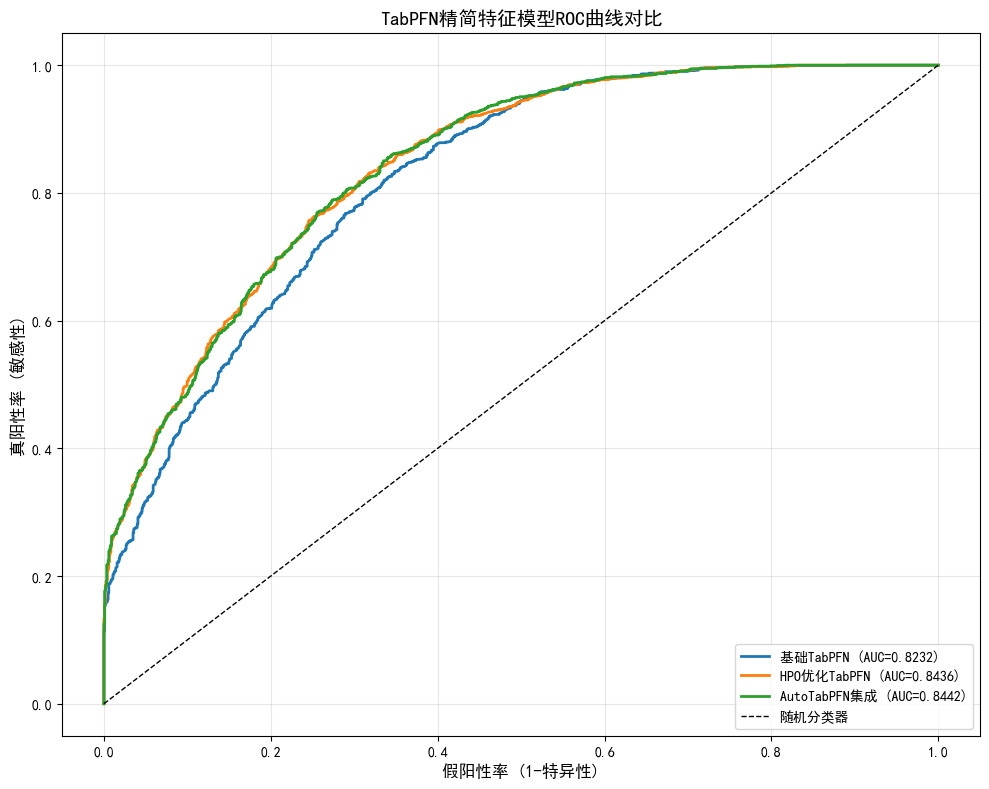

ROC曲线已保存


In [14]:
fig, ax = plt.subplots(figsize=(10, 8))

# 绘制各模型ROC曲线
models_data = [
    ("基础TabPFN", y_pred_proba_basic, auc_basic),
    ("HPO优化TabPFN", y_pred_proba_hpo, auc_hpo),
    ("AutoTabPFN集成", y_pred_proba_auto, auc_auto),
]

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

for (name, proba, auc), color in zip(models_data, colors):
    fpr, tpr, _ = roc_curve(y_validation_binary, proba)
    ax.plot(fpr, tpr, label=f"{name} (AUC={auc:.4f})", color=color, linewidth=2)

ax.plot([0, 1], [0, 1], "k--", linewidth=1, label="随机分类器")
ax.set_xlabel("假阳性率 (1-特异性)", fontsize=12)
ax.set_ylabel("真阳性率 (敏感性)", fontsize=12)
ax.set_title("TabPFN精简特征模型ROC曲线对比", fontsize=14)
ax.legend(loc="lower right", fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("./output/tabpfn_simplified/ROC曲线对比.png", dpi=300, bbox_inches="tight")
plt.savefig("./output/tabpfn_simplified/ROC曲线对比.pdf", bbox_inches="tight")
plt.show()
print("ROC曲线已保存")

## 14. SHAP特征重要性分析

In [ ]:
print("=" * 70)
print("SHAP特征重要性分析（精简特征）")
print("=" * 70)

# 使用最佳模型进行SHAP分析
best_model = tabpfn_hpo

# 采样用于SHAP分析
n_shap_samples = min(1000, len(X_validation_processed))
shap_indices = np.random.choice(
    len(X_validation_processed), n_shap_samples, replace=False
)
X_shap = X_validation_processed[shap_indices]

print(f"使用 {n_shap_samples} 个样本进行SHAP分析...")

# 计算SHAP值
shap_values = interpretability.shap_values(
    best_model,
    X_shap,
    feature_names=feature_cols_processed,
)

print("SHAP值计算完成")

In [ ]:
# SHAP Summary Plot
import shap

fig, ax = plt.subplots(figsize=(12, 10))
shap.summary_plot(
    shap_values,
    X_shap,
    feature_names=feature_cols_processed,
    show=False,
    max_display=21,
)
plt.title("SHAP特征重要性（精简特征）", fontsize=14)
plt.tight_layout()
plt.savefig("./output/tabpfn_simplified/SHAP_summary.png", dpi=300, bbox_inches="tight")
plt.savefig("./output/tabpfn_simplified/SHAP_summary.pdf", bbox_inches="tight")
plt.show()
print("SHAP Summary Plot已保存")

In [ ]:
# 计算特征重要性排名
shap_importance = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame(
    {
        "特征": feature_cols_processed,
        "SHAP重要性": shap_importance,
    }
).sort_values("SHAP重要性", ascending=False)

print("\n精简特征SHAP重要性排名:")
print("=" * 50)
for i, row in importance_df.iterrows():
    print(f"  {row['特征']}: {row['SHAP重要性']:.4f}")

# 保存
importance_df.to_csv(
    "./output/tabpfn_simplified/SHAP_feature_importance.csv", index=False
)
print("\n特征重要性已保存: ./output/tabpfn_simplified/SHAP_feature_importance.csv")

## 15. 详细性能指标

In [ ]:
def calculate_detailed_metrics(y_true, y_pred, y_proba):
    """计算详细性能指标"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0

    plr = sensitivity / (1 - specificity) if (1 - specificity) > 0 else float("inf")
    nlr = (1 - sensitivity) / specificity if specificity > 0 else float("inf")

    return {
        "AUC": roc_auc_score(y_true, y_proba),
        "F1": f1_score(y_true, y_pred),
        "准确率": accuracy_score(y_true, y_pred),
        "敏感性": sensitivity,
        "特异性": specificity,
        "PPV": ppv,
        "NPV": npv,
        "阳性似然比": plr,
        "阴性似然比": nlr,
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn,
    }


# 计算各模型详细指标
detailed_results = []
for name, pred, proba in [
    ("基础TabPFN", y_pred_basic, y_pred_proba_basic),
    ("HPO优化TabPFN", y_pred_hpo, y_pred_proba_hpo),
    ("AutoTabPFN集成", y_pred_auto, y_pred_proba_auto),
]:
    metrics = calculate_detailed_metrics(y_validation_binary, pred, proba)
    metrics["模型"] = name
    detailed_results.append(metrics)

detailed_df = pd.DataFrame(detailed_results)
cols = ["模型"] + [c for c in detailed_df.columns if c != "模型"]
detailed_df = detailed_df[cols]

print("\n详细性能指标:")
print("=" * 100)
print(detailed_df.to_string(index=False))

detailed_df.to_csv("./output/tabpfn_simplified/详细性能指标.csv", index=False)
print("\n已保存: ./output/tabpfn_simplified/详细性能指标.csv")

## 16. 保存验证集预测结果

In [ ]:
# 保存验证集预测结果
validation_results = validation_data.copy()
validation_results["真实标签"] = y_validation_binary.values
validation_results["基础TabPFN_预测"] = y_pred_basic
validation_results["基础TabPFN_概率"] = y_pred_proba_basic
validation_results["HPO_预测"] = y_pred_hpo
validation_results["HPO_概率"] = y_pred_proba_hpo
validation_results["Auto_预测"] = y_pred_auto
validation_results["Auto_概率"] = y_pred_proba_auto

validation_results.to_csv("./output/tabpfn_simplified/验证集预测结果.csv", index=False)
print(f"验证集预测结果已保存: ./output/tabpfn_simplified/验证集预测结果.csv")
print(f"共 {len(validation_results)} 条记录")

## 17. 总结

In [ ]:
print("=" * 70)
print("TabPFN精简特征模型训练完成")
print("=" * 70)
print(f"\n使用特征数: {len(feature_cols_processed)} (vs 全特征38个)")
print(f"训练样本: {len(X_train_sampled)}")
print(f"验证样本: {len(X_validation_processed)}")

print("\n模型性能汇总:")
print(results.to_string(index=False))

best_idx = results["AUC"].idxmax()
print(f"\n最佳模型: {results.loc[best_idx, '模型']}")
print(f"  AUC: {results.loc[best_idx, 'AUC']:.4f}")
print(f"  F1:  {results.loc[best_idx, 'F1']:.4f}")

print("\n输出文件:")
print("  - ./output/tabpfn_simplified/models/  (模型文件)")
print("  - ./output/tabpfn_simplified/性能对比.csv")
print("  - ./output/tabpfn_simplified/详细性能指标.csv")
print("  - ./output/tabpfn_simplified/ROC曲线对比.png")
print("  - ./output/tabpfn_simplified/SHAP_summary.png")
print("  - ./output/tabpfn_simplified/SHAP_feature_importance.csv")
print("  - ./output/tabpfn_simplified/验证集预测结果.csv")